# 1. Import Library

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.random import set_seed
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import RMSprop, SGD, Adam, Nadam
from tensorflow.keras.regularizers import l1, l2, L1L2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


import cv2 as cv
import time

set_seed(0)
np.random.seed(0)

# 2. Data Preprocessing


In [32]:
path = "C:/Users/javie/Documents/Kuliah/Semester 6/Bangkit/Capstone/Dataset"

In [33]:
train_datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range = 20,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        horizontal_flip = True,
        vertical_flip = True,
        fill_mode='nearest'
)
validation_datagen = ImageDataGenerator(
        rescale = 1./255
)
test_datagen = ImageDataGenerator(
        rescale = 1./255
)

In [34]:
img_shape = (224, 224, 3) # default values

train_batch_size = 256
val_batch_size = 32

train_generator = train_datagen.flow_from_directory(
            path + '/train',
            target_size = (img_shape[0], img_shape[1]),
            batch_size = train_batch_size,
            class_mode = 'categorical',)

validation_generator = validation_datagen.flow_from_directory(
            path + '/val',
            target_size = (img_shape[0], img_shape[1]),
            batch_size = val_batch_size,
            class_mode = 'categorical',
            shuffle=False)

test_generator = test_datagen.flow_from_directory(
            path + '/test',
            target_size = (img_shape[0], img_shape[1]),
            batch_size = val_batch_size,
            class_mode = 'categorical',
            shuffle=False,)

Found 437 images belonging to 17 classes.
Found 235 images belonging to 17 classes.
Found 289 images belonging to 17 classes.


In [35]:
class_indices = train_generator.class_indices
classes = list(class_indices.keys())
print(classes)

['Botol Obat Rev', 'Botol Susu Bayi', 'Botol Tupperware', 'Botol susu dan jus', 'Botol yang bisa ditekan', 'CD', 'Frozen Food Rev', 'Kemasan Mentega', 'Makanan Ringan Rev', 'Plastik', 'Sedotan Rev', 'Styrofoam Rev', 'botolminyak', 'botolplastik', 'detergen', 'pipa', 'thinwall']


# 3. Arsitektur Model

Menggunakan VGG16

In [36]:
vgg = VGG16(weights = 'imagenet',
              include_top = False,
              input_shape = img_shape)

In [37]:
for layer in vgg.layers[:-3]:
    layer.trainable = False

In [39]:
model = Sequential()
 
# Add the vgg convolutional base model
model.add(vgg)
 
# Add new layers
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(classes), activation='softmax'))

In [40]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 4,719,616 (18.00 MB)

 Non-trainable params: 9,995,072 (38.13 MB)

# 4. Training

In [41]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tensorflow.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

In [42]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    verbose=1,
    patience=10
)

# Menyesuaikan ModelCheckpoint
mc = tf.keras.callbacks.ModelCheckpoint(
    'VGG16_Garbage_Classifier.h5', 
    monitor='val_accuracy',  
    mode='max',
    verbose=1,
    save_best_only=True
)

# Melatih model dengan menggunakan callback yang telah disesuaikan
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    verbose=1,
    callbacks=[es, mc]  
)

Epoch 1/15


C:\Users\javie\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 88s 36s/step - accuracy: 0.0945 - loss: 3.1647 - val_accuracy: 0.1574 - val_loss: 2.6713
Epoch 2/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 51s 24s/step - accuracy: 0.1593 - loss: 2.6873 - val_accuracy: 0.2723 - val_loss: 2.4207
Epoch 3/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 48s 23s/step - accuracy: 0.2684 - loss: 2.4181 - val_accuracy: 0.4596 - val_loss: 2.2085
Epoch 4/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 27s/step - accuracy: 0.4109 - loss: 2.2045 - val_accuracy: 0.4596 - val_loss: 1.8914
Epoch 5/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 26s/step - accuracy: 0.4301 - loss: 1.8783 - val_accuracy: 0.5234 - val_loss: 1.5648
Epoch 6/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 22s/step - accuracy: 0.5417 - loss: 1.5364 - val_accuracy: 0.5574 - val_loss: 1.4169
Epoch 7/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 46s 23s/step - accuracy: 0.5602 - loss: 1.3574 - val_accuracy: 0.6340 - val_loss: 1.1653
Epoch 8/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 46s 24s/step - accuracy: 0.6971 - loss: 1.0532 - val_accuracy: 0.6681 - val_loss: 1.0677
Epoch 9/15


In [44]:
model.save('PlasticWise.h5')

# 5. Evaluasi Model

8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step
                         precision    recall  f1-score   support

         Botol Obat Rev       1.00      0.20      0.33         5
        Botol Susu Bayi       0.50      0.58      0.54        12
       Botol Tupperware       0.80      0.86      0.83        14
     Botol susu dan jus       0.29      0.40      0.33         5
Botol yang bisa ditekan       0.86      0.80      0.83        15
                     CD       0.87      1.00      0.93        13
        Frozen Food Rev       0.71      0.94      0.81        18
        Kemasan Mentega       1.00      0.67      0.80         3
     Makanan Ringan Rev       1.00      0.60      0.75         5
                Plastik       0.00      0.00      0.00         5
            Sedotan Rev       1.00      0.71      0.83         7
          Styrofoam Rev       0.87      0.92      0.89        50
            botolminyak       0.59      0.93      0.72        14
           botolplastik       1.00      0.57      0.

C:\Users\javie\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\javie\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\javie\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


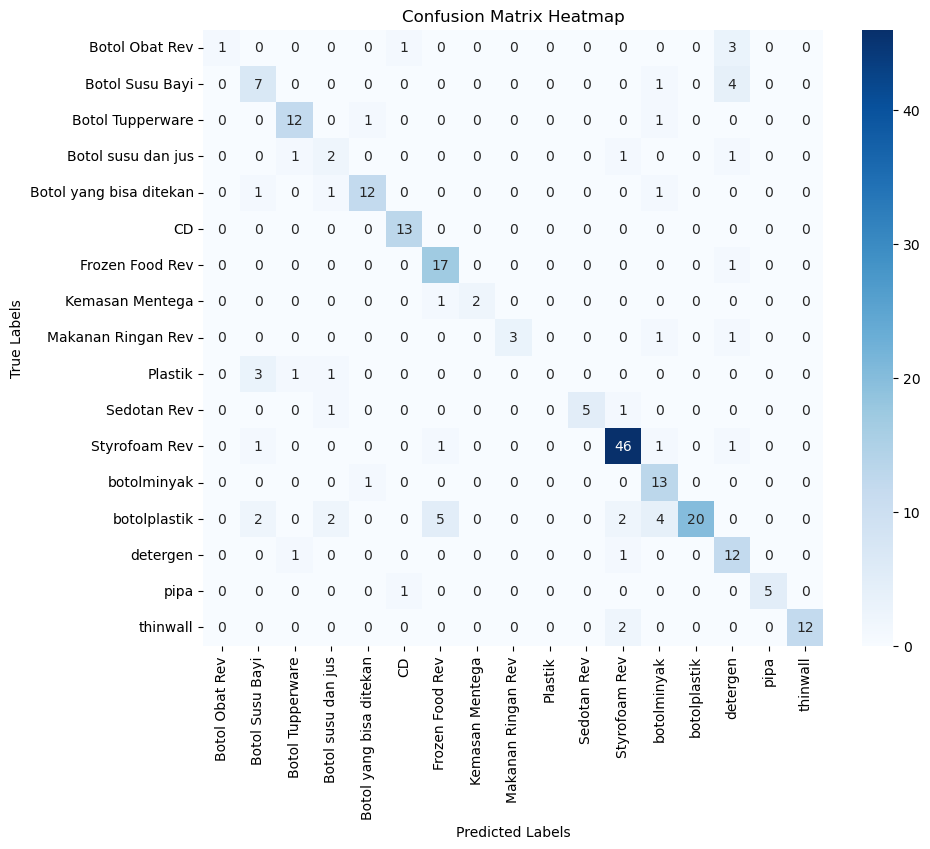

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Prediksi kelas dari data validasi
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
true_classes = validation_generator.classes

# Classification Report
print(classification_report(true_classes, y_pred_classes, target_names=classes))

# Confusion Matrix
conf_matrix = confusion_matrix(true_classes, y_pred_classes)

# Plot Confusion Matrix as Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

# 6. Deployment

Deploy nya pindah di Colab, versi tf sm tfjs gw ga sama wkwk

In [90]:
!pip install tensorflow tensorflowjs


In [58]:
import tensorflowjs as tfjs

ImportError: cannot import name 'disable_resource_variables' from 'tensorflow.python.ops.variable_scope' (C:\Users\javie\anaconda3\Lib\site-packages\tensorflow\python\ops\variable_scope.py)

In [80]:
model = load_model('PlasticWise.h5')

In [82]:
def preprocess_frame(frame):
    # Mengubah ukuran frame sesuai dengan input model
    resized_frame = cv.resize(frame, (224, 224))  # Sesuaikan ukuran sesuai dengan input model Anda
    # Normalisasi atau skala pixel (jika diperlukan oleh model)
    normalized_frame = resized_frame / 255.0
    # Menambahkan dimensi batch
    input_frame = np.expand_dims(normalized_frame, axis=0)
    return input_frame

# Fungsi untuk memprediksi objek pada frame
def predict(frame):
    preprocessed_frame = preprocess_frame(frame)
    predictions = model.predict(preprocessed_frame)
    return predictions

# Fungsi untuk menampilkan hasil prediksi
def display_predictions(frame, predictions):
    # Misalnya, kita memiliki daftar label kelas
    class_labels = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
    predicted_class = np.argmax(predictions)
    predicted_label = class_labels[predicted_class]
    confidence = predictions[0][predicted_class]
    #print(predictions)

    # Menampilkan label dan confidence pada frame
    cv.putText(frame, f'{predicted_label}: {confidence:.2f}', (10, 30), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    return frame

In [83]:
cap = cv.VideoCapture(3)

In [84]:
while True:
    # Membaca frame dari kamera
    ret, frame = cap.read()
    if not ret:
        break
    
    # Melakukan prediksi pada frame
    predictions = predict(frame)
    
    # Menampilkan hasil prediksi pada frame
    frame_with_predictions = display_predictions(frame, predictions)
    
    # Menampilkan frame dengan prediksi
    cv.imshow('Real-time Object Classification', frame_with_predictions)
    
    # Tekan 'q' untuk keluar dari loop
    if cv.waitKey(1) & 0xFF == ord('q'):
        break

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

KeyboardInterrupt: 

In [85]:
cap.release()
cv.destroyAllWindows()